In [1]:
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from sys import path
import os

for dirname, _, filenames in os.walk("../../resources/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath("../../"))

from custom import functions

warnings.filterwarnings("ignore")

../../resources/allColProSol.xlsx
../../resources/dataset_a_2021.csv
../../resources/dataset_a_2021c2.csv
../../resources/dataset_a_2021v1.xlsx
../../resources/dataset_unab_ORIGINAL SIN P1.csv
../../resources/dataset_unab_P1.csv
../../resources/exitoFallidoEnviosProgramaSol.xlsx
../../resources/exitoFallidoProgramaSol.xlsx
../../resources/exitosoFallidosEnviosAllColProSol.xlsx
../../resources/exitosoFallidosEnviosAllColSol.xlsx
../../resources/exitososFallidosEnviosSol.xlsx
../../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../../resources/sinColCeroExitosoFallidosSol.xlsx
../../resources/v2_hitosExitoFalloColESol1.csv
../../resources/v2_hitosExitoFalloColESol1Prograna.csv
../../resources/v2_hitosExitoFalloSol1Programa.csv
../../resources/causalidad\causalidad.dot
../../resources/causalidad\causalidad.png
../../resources/causalidad\causalidad_e29.dot
../../resources/causalidad\graph_causal_model_e29.png
../../resources/causal

In [2]:
# Read and preview data
df = pd.read_csv(
    "../../resources/v2_hitosExitoFalloColESol1.csv", delimiter=";", skipinitialspace=True
)

In [3]:
# creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df["aprobado"] = df.apply(lambda x: functions.set_in_aprobado_nota(x["sol1"]), axis=1)
# revisamos la existencia de la nueva columna.
print(df.columns)

Index(['hito1', 'hito2', 'exitosos', 'fallidos', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15',
       'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25',
       'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35',
       'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45',
       'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'sol1', 'aprobado'],
      dtype='object')


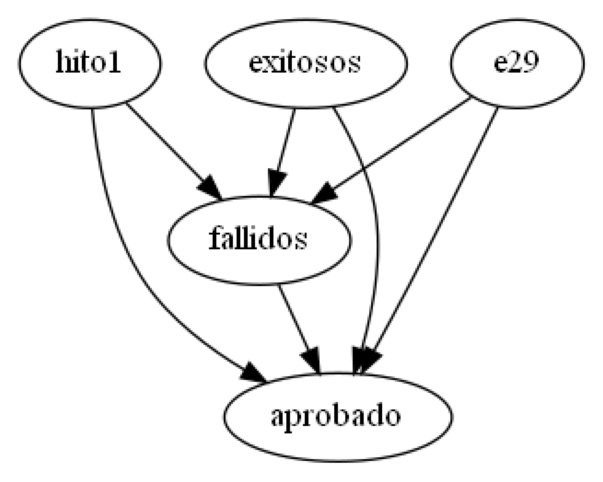

In [4]:
# Paso 1: Modelar un problema causal
model = CausalModel(
    data=df,
    treatment="fallidos",  # Variable tratada (exposición)
    outcome="aprobado",  # Variable de resultado
    common_causes=[
        "hito1",
        "exitosos",
        "e29"
    ],  # Variables de causa común
)
# Visualizar el modelo causal con la variable de causa común no observada
model.view_model(
    layout="dot",
    file_name="../../resources/causalidad/graph_causal_model_fallidos",
)

In [5]:
# Paso 2: Identificar el estimando objetivo bajo el modelo
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
───────────(E[aprobado|e29,hito1,exitosos])
d[fallidos]                                
Estimand assumption 1, Unconfoundedness: If U→{fallidos} and U→aprobado then P(aprobado|fallidos,e29,hito1,exitosos,U) = P(aprobado|fallidos,e29,hito1,exitosos)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
# Paso 3: Estimar el efecto causal usando un método basado en árboles
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value=0,
    treatment_value=1,
    target_units="ate",  # Average Treatment Effect
    method_params={
        "init_params": {
            "model_y": RandomForestRegressor(),
            "model_t": RandomForestRegressor(),
            "model_final": RandomForestRegressor(
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=1502,
                n_estimators=500,
            ),
            "featurizer": None,
        },
        "fit_params": {},
    },
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
───────────(E[aprobado|e29,hito1,exitosos])
d[fallidos]                                
Estimand assumption 1, Unconfoundedness: If U→{fallidos} and U→aprobado then P(aprobado|fallidos,e29,hito1,exitosos,U) = P(aprobado|fallidos,e29,hito1,exitosos)

## Realized estimand
b: aprobado~fallidos+e29+hito1+exitosos | 
Target units: ate

## Estimate
Mean value: 0.12757489211466105
Effect estimates: [[0.12757489]]



In [7]:
# Refutador de datos aleatorios
refute1 = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)
print(refute1)

Refute: Add a random common cause
Estimated effect:0.12757489211466105
New effect:-0.0031753888658177143
p value:0.3



In [8]:
# Refutador de causa común no observada
refute2 = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.01,
    effect_strength_on_outcome=0.02,
)
print(refute2)

Refute: Add an Unobserved Common Cause
Estimated effect:0.12757489211466105
New effect:-0.05021899142733498



In [9]:
# Paso 4: Refutar el estimado obtenido
refute3 = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)
print(refute3)

Refute: Use a Placebo Treatment
Estimated effect:0.12757489211466105
New effect:-0.0011274444389418933
p value:0.96

